In [67]:
import pickle as p
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from tqdm import tqdm
from dfa import dfa
import scipy.signal as sig
from sklearn.linear_model import LogisticRegression
from scipy.interpolate import interp1d
from scipy.integrate import romb
plt.rcParams.update({'font.size': 22})

In [68]:
n_splits = 5

def num_to_epoch(epoch_number):
    if epoch_number == 0:
        return 'UP1'
    elif epoch_number == 1:
        return 'UP2'
    elif epoch_number == 2:
        return 'P1'
    elif epoch_number == 3:
        return 'P2'
    elif epoch_number == 4:
        return 'REC'
    else:
        raise Exception('Invalid Epoch Number')

def num_to_subject(subject_number):
    return 'Subject'+str(subject_number)

def get_signal(measure, epoch, subjno):
    if isinstance(epoch,str):
        return np.ravel(df.loc[measure, epoch][num_to_subject(subjno)])
    elif isinstance(epoch, int):
        return np.ravel(df.loc[measure, num_to_epoch(epoch)][num_to_subject(subjno)])

def get_split_signal(measure, epoch, subjno, splitno):
    if isinstance(epoch,str):
        return np.array_split(np.ravel(df.loc[measure, epoch][num_to_subject(subjno)]), n_splits)[splitno]
    elif isinstance(epoch, int):
        return np.array_split(np.ravel(df.loc[measure, num_to_epoch(epoch)][num_to_subject(subjno)]),n_splits)[splitno]
    
def full_signal(measure, subjno):
    return np.concatenate((
        np.ravel(df.loc[measure, num_to_epoch(0)][num_to_subject(subjno)]),
        np.ravel(df.loc[measure, num_to_epoch(1)][num_to_subject(subjno)]),
        np.ravel(df.loc[measure, num_to_epoch(2)][num_to_subject(subjno)]),
        np.ravel(df.loc[measure, num_to_epoch(3)][num_to_subject(subjno)]),
        np.ravel(df.loc[measure, num_to_epoch(4)][num_to_subject(subjno)]),
    ))

def is_perturbed(epoch):
    if epoch == 0 or epoch == 1 or epoch == 4:
        return 0
    elif epoch == 2 or epoch == 3:
        return 1
    
def scaled_correlation_time(signal1, signal2):
    signal1 = (signal1 - np.mean(signal1))/np.std(signal1)
    signal2 = (signal2 - np.mean(signal2))/np.std(signal2)
    acorr = np.correlate(signal1, signal2, mode='full')
    acorr = acorr[(acorr.size // 2 ):] / np.max(acorr)
#     plt.plot(acorr)
    tau = np.argmax([acorr < 1/np.exp(1)])
    return tau / len(acorr)

def correlation_integral(signal1, signal2):
    signal1 = (signal1 - np.mean(signal1))/np.std(signal1)
    signal2 = (signal2 - np.mean(signal2))/np.std(signal2)
    acorr = np.correlate(signal1, signal2, mode='full')
    acorr = acorr[(acorr.size // 2 ):] / np.max(acorr)
#     plt.plot(acorr)
    integral = np.trapz(acorr)
    return integral

def plot_full_experiment(measure, subjno):
    s1 = np.ravel(df.loc[measure, num_to_epoch(0)][num_to_subject(subjno)])
    s2 = np.ravel(df.loc[measure, num_to_epoch(1)][num_to_subject(subjno)])
    s3 = np.ravel(df.loc[measure, num_to_epoch(2)][num_to_subject(subjno)])
    s4 = np.ravel(df.loc[measure, num_to_epoch(3)][num_to_subject(subjno)])
    s5 = np.ravel(df.loc[measure, num_to_epoch(4)][num_to_subject(subjno)])
    fullsignal = np.concatenate((s1,s2,s3,s4,s5))
    plt.plot(fullsignal,'k',label = measure)
    plt.axvline(x = len(s1), color = 'k', linestyle = '--')
    plt.axvline(x = len(s1)+len(s2), color = 'k', linestyle = '--')
    plt.axvline(x = len(s1)+len(s2)+len(s3), color = 'k', linestyle = '--')
    plt.axvline(x = len(s1)+len(s2)+len(s3)+len(s4), color = 'k', linestyle = '--')
    plt.legend()

In [69]:
df = p.load(open('df.p','rb'))

all_subjects = np.concatenate((np.arange(11,25),np.arange(26,45)))

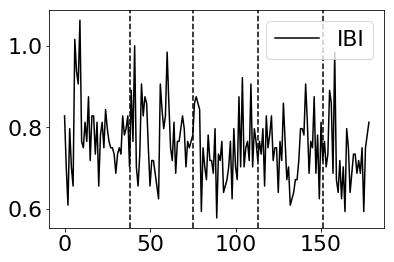

In [70]:
plot_full_experiment('IBI',26)

In [71]:
ibi = get_signal('IBI',0,41)

## IBI Frequency Passbands

In [72]:
#Get sample signal

signal = get_signal('IBI', 3, 12)

#Define analysis function
def ibi_passbands(signal):
    fs,pxx = sig.periodogram(signal, nfft = 1000, scaling = 'density', detrend = 'constant')
    # plt.figure()
    # plt.plot(fs,pxx)
    # plt.xlim(0,0.05)
    # plt.xlabel('Frequency (Hz.)')
    # plt.ylabel('Spectral Density')

    vlfband = (fs > 0.0033)*(fs < 0.04)
    lfband = (fs > 0.04)*(fs < 0.15)
    hfband = (fs > 0.15) * (fs < 0.4)

    # plt.figure(figsize = (13,7))
    # plt.plot(fs,pxx,'k')
    # #plt.xlim(0,0.05)
    # plt.xlabel('Frequency (Hz.)')
    # plt.ylabel('Spectral Density')
    # plt.plot(fs,vlfband*np.max(pxx),label = 'VLF')
    # plt.plot(fs,lfband*np.max(pxx),label = 'LF')
    # plt.plot(fs,hfband*np.max(pxx),label = 'HF')
    # plt.title('IBI Frequency Passbands')
    # plt.legend()

    vlf_integral = np.trapz(pxx[vlfband],fs[vlfband])
    lf_integral = np.trapz(pxx[lfband],fs[lfband])
    hf_integral = np.trapz(pxx[hfband],fs[hfband])

    return [vlf_integral,lf_integral,hf_integral]

#test function

ibi_passbands(signal)

[0.00024016656560907706, 0.00173628307267934, 0.003353883387386369]

In [94]:
allfeatures = [];
targets = [];
n_splits = 10

for subjno in tqdm(all_subjects):
    for epoch in range(4):
        for splitno in range(n_splits):
            ibi_signal = get_split_signal('IBI',epoch,subjno,splitno)
            

            allfeature = ibi_passbands(ibi_signal)
            allfeatures.append(allfeature)
            targets.append(is_perturbed(epoch))

allfeature_names = ['vlf','hf','lf']
fdf = pd.DataFrame(allfeatures, columns = allfeature_names)

100%|██████████| 33/33 [00:00<00:00, 54.68it/s]


In [95]:
targets = np.asarray(targets)

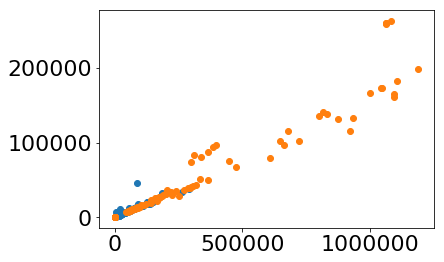

In [96]:
plt.scatter(fdf['lf'][targets == 0], fdf['hf'][targets == 0])
plt.scatter(fdf['lf'][targets == 1], fdf['hf'][targets == 1])

In [97]:
fdf['lf/hf'] = fdf['lf'] / (fdf['hf'])

In [98]:
up = np.asarray(fdf['lf/hf'][targets == 0])
p = np.asarray(fdf['lf/hf'][targets == 1])

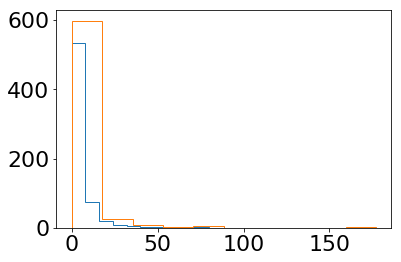

In [99]:
plt.hist(up, histtype = 'step');
plt.hist(p, histtype = 'step');

In [100]:
nonan = (~np.isnan(p)) * (~np.isnan(up))

stats.f_oneway(up[nonan],p[nonan])

F_onewayResult(statistic=6.721109009687362, pvalue=0.00963776084092749)